# Setup

In [48]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
from locale import atof
from dateutil import parser
from datetime import datetime

matplotlib.rcParams['figure.figsize'] = (12, 6)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')


# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

First, download the zipfile and unzip it in `data` directory.

**@TODO**: Cache zip files locally, read from zip into ignored local file.

In [2]:
response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/master_2017.json.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('data')

Open the downloaded, unzipped JSON file, run sentiment analysis, remove multi-valued `entities` field, and create `data/master_2017_processed.json`.

In [3]:
with open('data/master_2017.json') as f:
    jsondata = json.load(f)

analyzer = SentimentIntensityAnalyzer()
for row in jsondata:
    del(row['entities'])
    vs = analyzer.polarity_scores(row['text'])
    row['sentiment'] = vs

with open('data/master_2017_processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [4]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [5]:
with open('data/master_2017_processed.json') as f:
    jsondata = json.load(f)
normalized_json = pd.io.json.json_normalize(jsondata)
tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])

Add many time grouping columns.

In [6]:
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets.set_index('created_date', inplace=True)

# Frequencies

## Total Tweets

In [7]:
len(tweets.index)

620

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

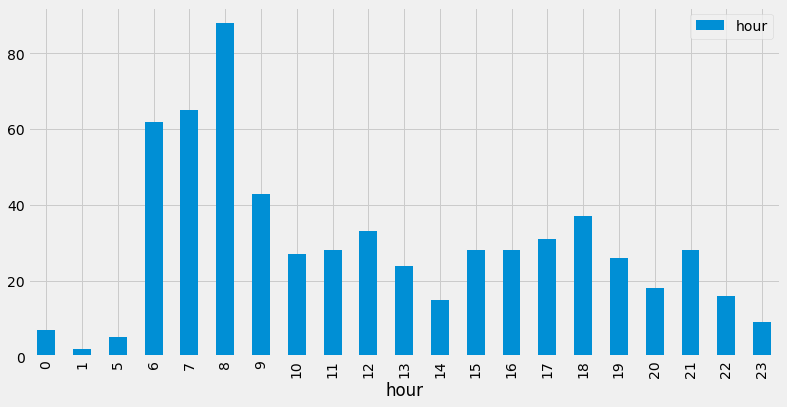

In [8]:
tweetsPerHour = tweets[['hour']].groupby(tweets['hour']).count()
tweetsPerHour.plot(kind='bar')

## Tweets per day

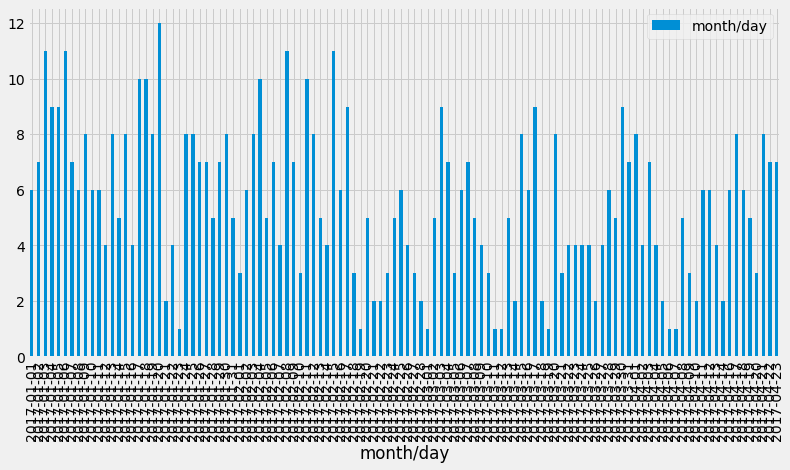

In [9]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
tweetsPerDay.plot(kind='bar')

In [10]:
tweetsPerDay.describe()

,month/day
count,112.000000
mean,5.535714
std,2.721051
min,1.000000
25%,3.750000
50%,5.500000
75%,8.000000
max,12.000000


## Tweets per day of week

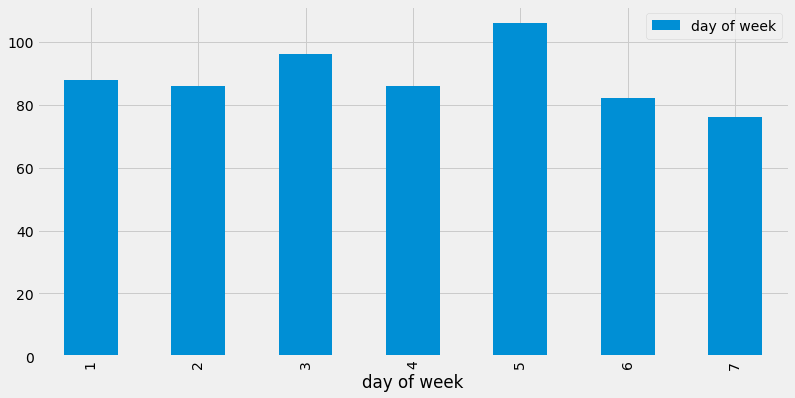

In [11]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.plot(kind='bar')

## Tweets per month

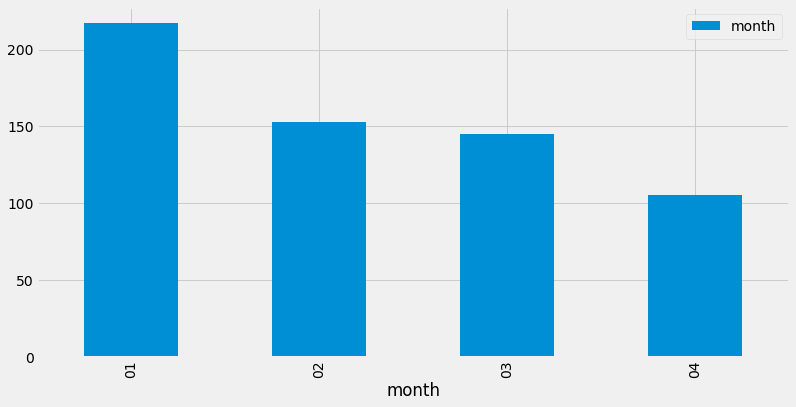

In [12]:
tweetsPerMonth = tweets[['month']].groupby(tweets['month']).count()
tweetsPerMonth.plot(kind='bar')

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## By month

In [14]:
sentiment_fields = ['sentiment.compound', 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

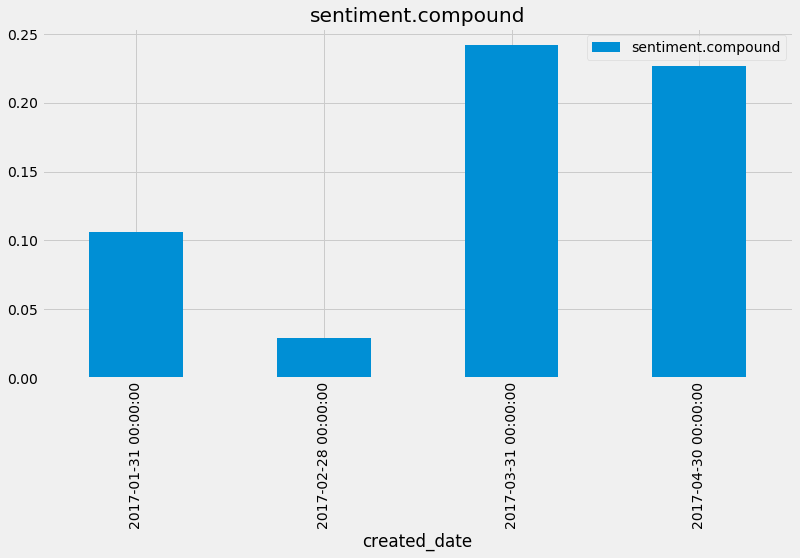

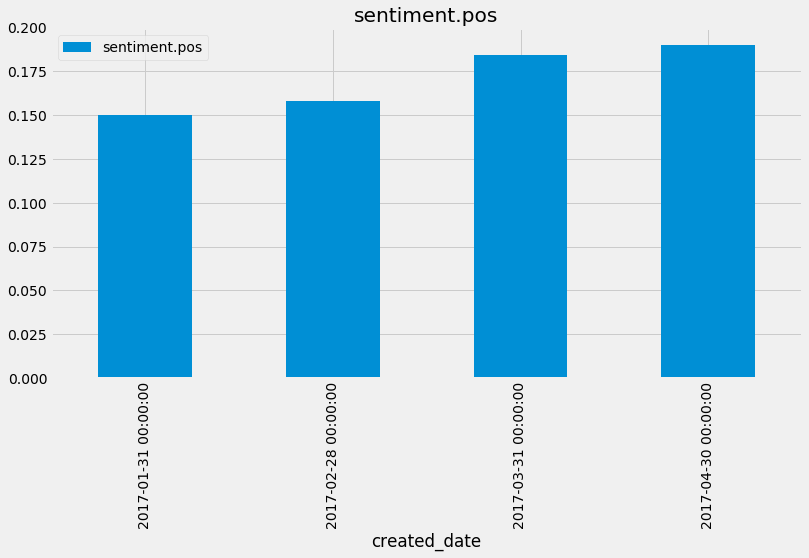

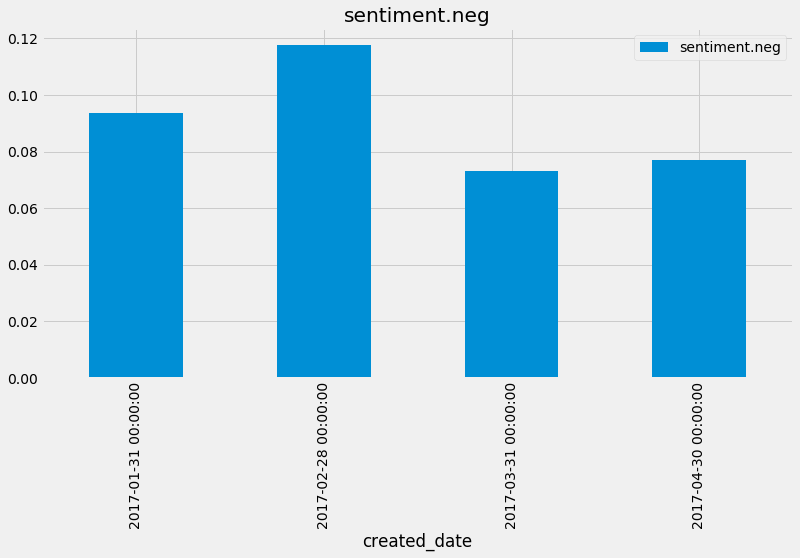

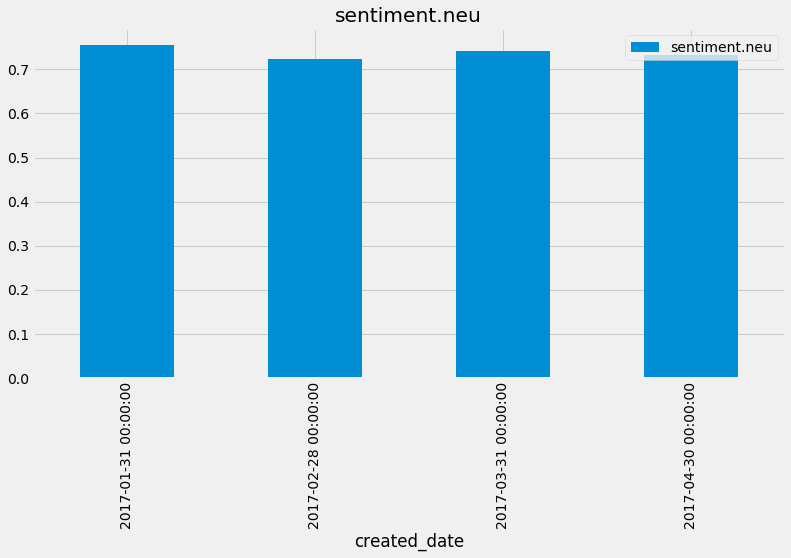

In [15]:
for field in sentiment_fields:
    tweets[[field]].resample('M').mean().plot(kind='bar', title=field)

## By week

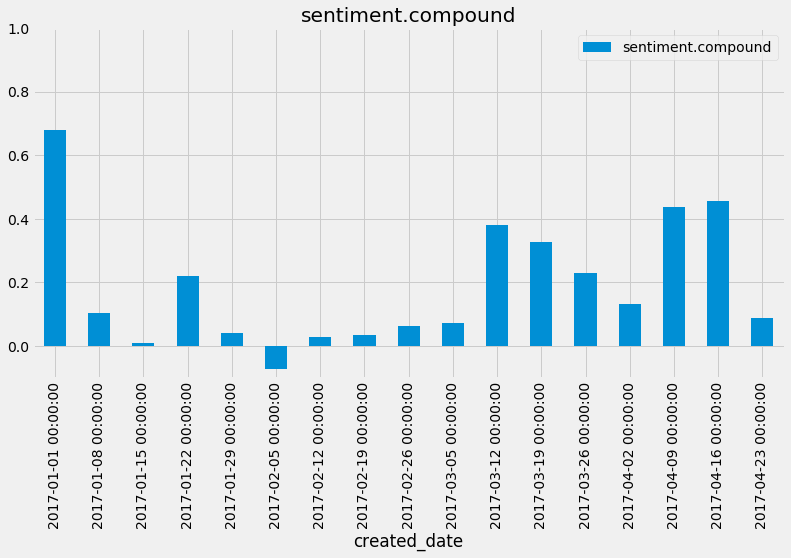

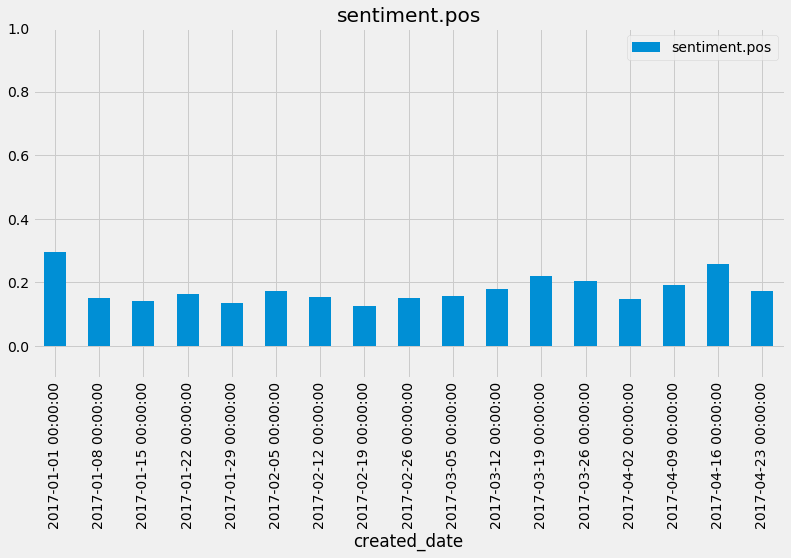

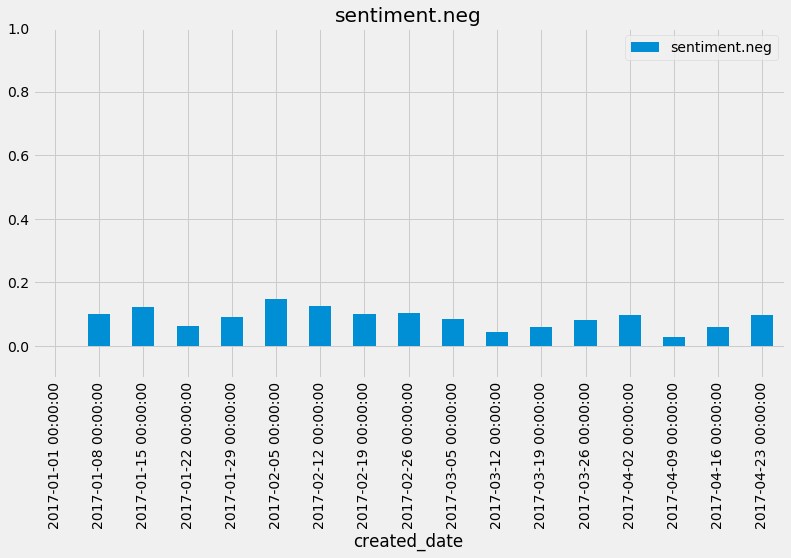

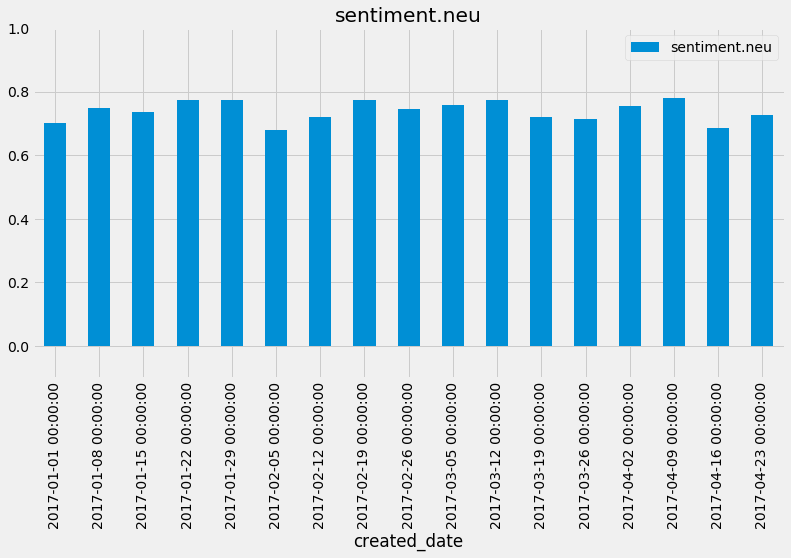

In [16]:
for field in sentiment_fields:
    tweets[[field]].resample('W').mean().plot(kind='bar', title=field, ylim=[-0.1,1])

## Every Tweet's sentiment analysis

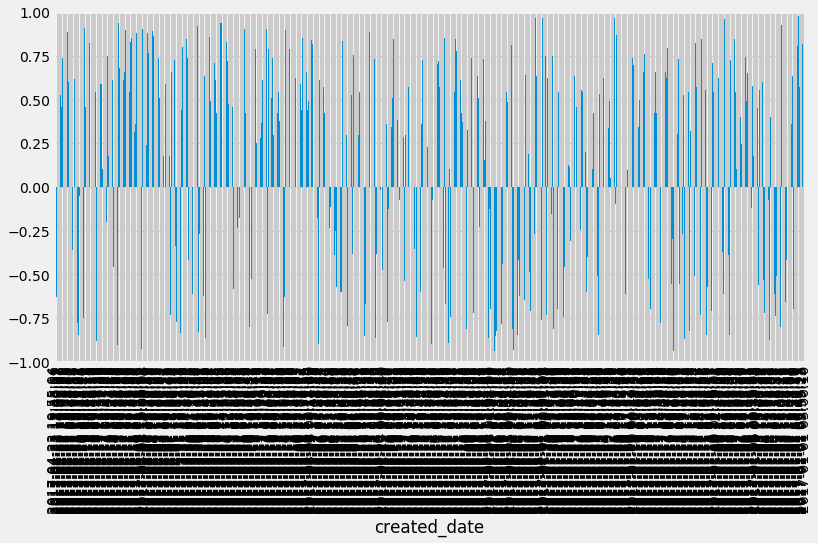

In [17]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1])

# Follower count

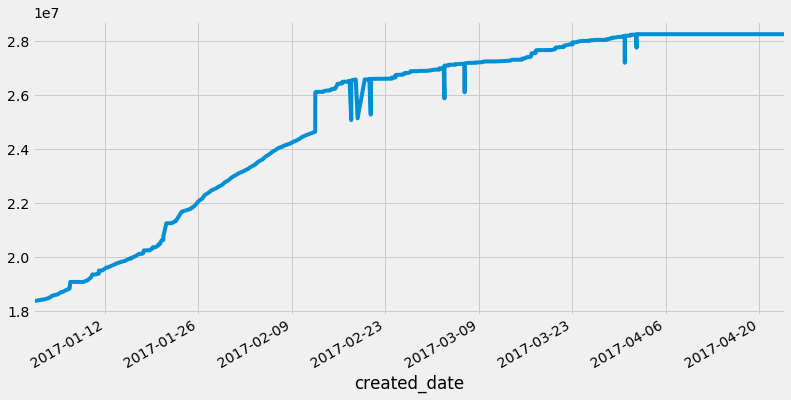

In [18]:
tweets['user.followers_count'].plot()

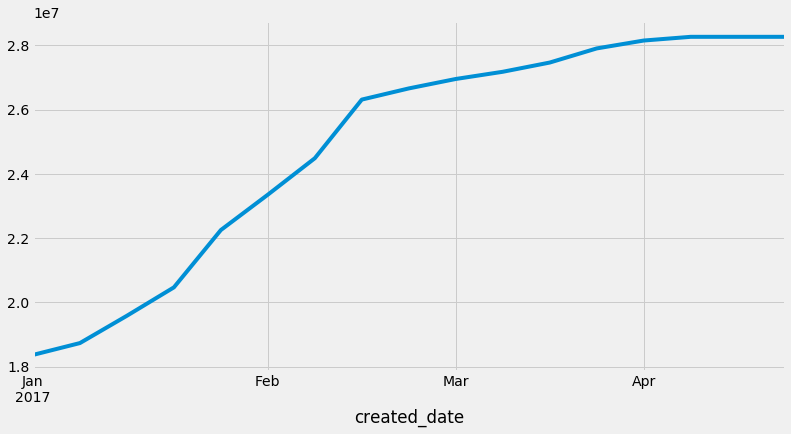

In [19]:
tweets['user.followers_count'].resample('W').plot()

# Text analysis

Let's look for some search terms.

In [20]:
pd.options.display.max_colwidth = 140

## "fake news"

In [21]:
fakenews = tweets[tweets['text'].str.contains('fake', case=False)]

Number and percent of tweets that mention "fake" news or media.

In [22]:
len(fakenews)

48

In [23]:
float(len(fakenews))/len(tweets) * 100

7.741935483870968

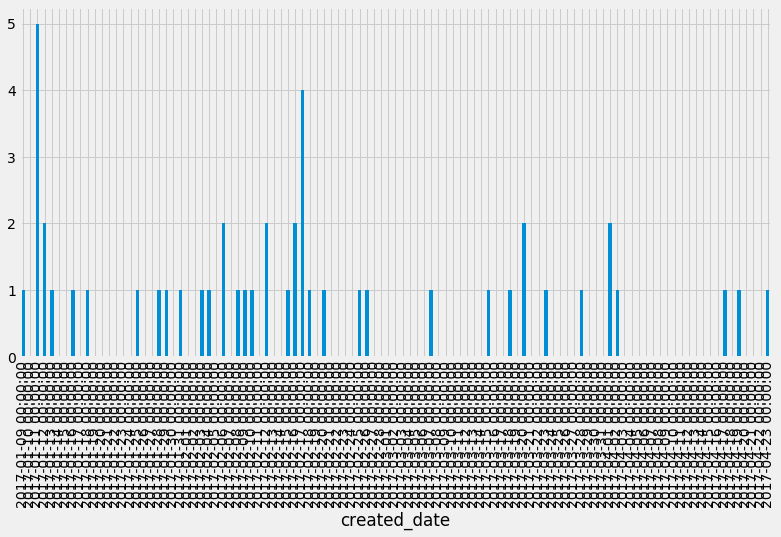

In [24]:
fakenews['id'].resample('D').count().plot(kind='bar')

In [25]:
print(fakenews.to_csv(columns=['text'], sep='\t', index=False))

text
New polls out today are very good considering that much of the media is FAKE and almost always negative. Would still beat Hillary in .....
"Despite major outside money, FAKE media support and eleven Republican candidates, BIG ""R"" win with runoff in Georgia. Glad to be of help!"
The Fake Media (not Real Media) has gotten even worse since the election. Every story is badly slanted. We have to hold them to the truth!
Anybody (especially  Fake News media) who thinks that Repeal &amp; Replace of ObamaCare is dead does not know the love and strength in R Party!
"It is the same Fake News Media that said there is ""no path to victory for Trump"" that is now pushing the phony Russia story. A total scam!"
When will Sleepy Eyes Chuck Todd and @NBCNews start talking about the Obama SURVEILLANCE SCANDAL and stop with the Fake Trump/Russia story?
Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?
Just watched the 

## "ms13"

In [26]:
ms13 = tweets[tweets['text'].str.contains('ms 13', case=False)]

In [27]:
len(ms13)

2

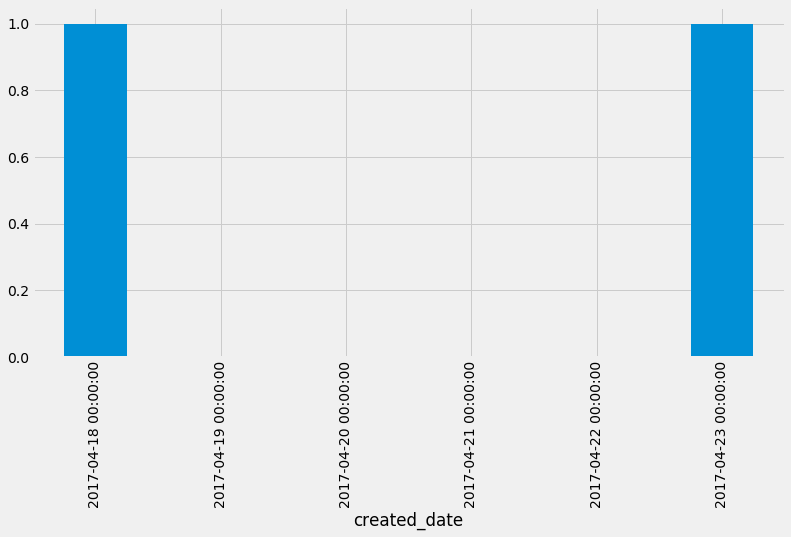

In [30]:
ms13['id'].resample('D').count().plot(kind='bar')

## "mexic"

In [34]:
mexico = tweets[tweets['text'].str.contains('mexic', case=False)]

In [35]:
len(mexico)

11

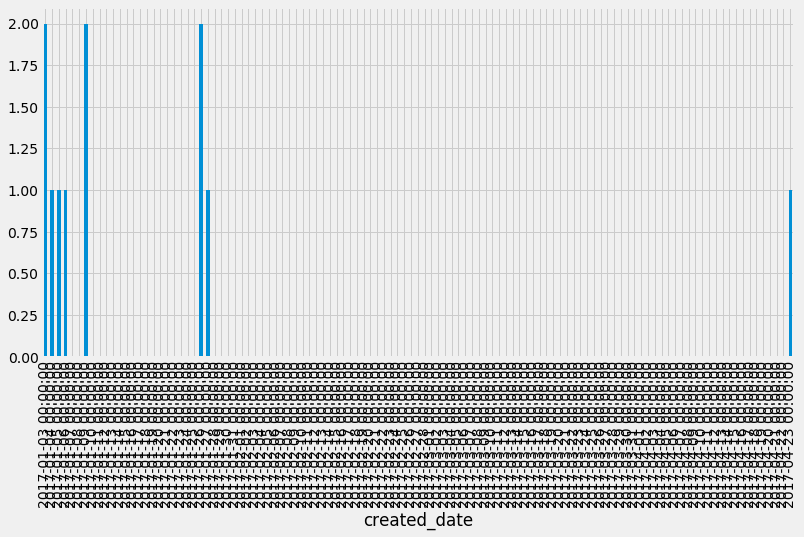

In [36]:
mexico['id'].resample('D').count().plot(kind='bar')

## "terror"

In [37]:
terror = tweets[tweets['text'].str.contains('terror', case=False)]

In [38]:
len(terror)

10

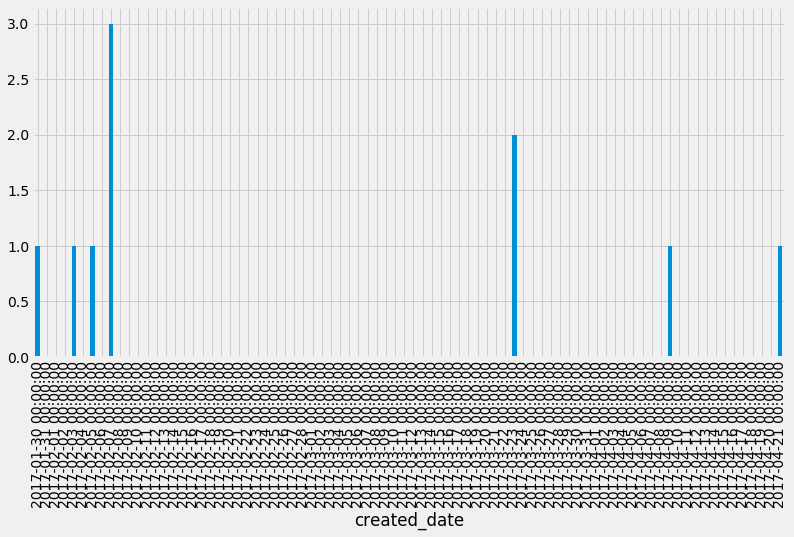

In [39]:
terror['id'].resample('D').count().plot(kind='bar')

## Fox

In [41]:
fox = tweets[tweets['text'].str.contains('fox', case=False)]

In [42]:
len(fox)

37

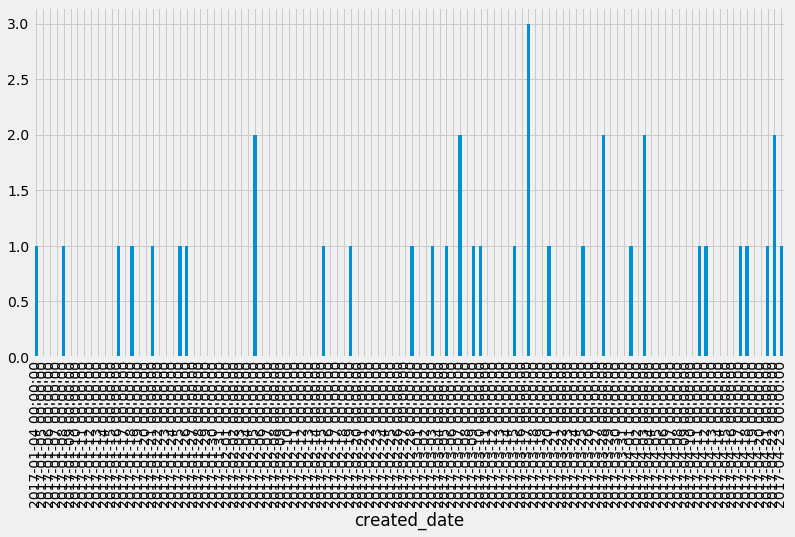

In [43]:
fox['id'].resample('D').count().plot(kind='bar')

In [46]:
foxTweetsPerHour = fox[['hour']].groupby(fox['hour']).count()

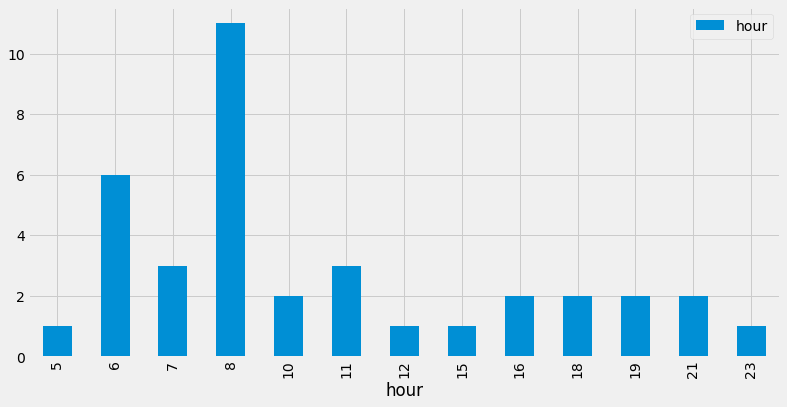

In [47]:
foxTweetsPerHour.plot(kind='bar')